In [1]:
%load_ext autoreload
%autoreload 2

from celeste_rl.level import *
from celeste_rl.env import *
# from celeste_rl.models import *
from rtgym import DEFAULT_CONFIG_DICT
# from stable_baselines3.common.monitor import Monitor
# from stable_baselines3 import PPO
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import cv2
import gymnasium

import zmq
import numpy as np
import matplotlib.pyplot as plt
import cv2

import PIL.Image as Image
import io
import json
import base64

from celeste_rl.env import CelesteImgGym
import gymnasium as gym
from ray.rllib.algorithms.r2d2 import R2D2, R2D2Config, R2D2TorchPolicy


from ray.air.integrations.wandb import WandbLoggerCallback

from gymnasium.envs.registration import EnvSpec
import ray
from gymnasium.wrappers import TimeLimit

class EnvCreator:
    
    def __init__(self, port=7777):
        self.port = port
    
    def get_env(self, config):
        env = TimeLimit(CelesteImgGym(self.port), max_episode_steps=2000)
        self.port += 1
        return env
    
    
from ray.tune.registry import register_env

creator = EnvCreator()
register_env("Celeste", creator.get_env)

In [2]:
config = R2D2Config()

config.replay_buffer_config.update(
     {
         "capacity": 100000,
         "replay_burn_in": 20,
         "type": "MultiAgentReplayBuffer",
         "prioritized_replay": True,
         "prioritized_replay_alpha": 0.6,
          # Beta parameter for sampling from prioritized replay buffer.
         "prioritized_replay_beta": 0.4,
         "replay_sequence_length":-1
     }
)

config.model.update(use_lstm=True,
                    lstm_cell_size=64,
                    max_seq_len=20)

config.lr = .0005
config.num_envs_per_worker = 2
#config.compress_observations = True
(config
 .training(replay_buffer_config=config.replay_buffer_config)
 .resources(num_gpus=1)
 .rollouts(num_rollout_workers=1)
 .environment("Celeste")
)


In [ ]:
#algo = R2D2(config=config)  
analysis = ray.tune.run(R2D2,
                        config=config,
                        stop={"training_iteration": 10_000},
                        checkpoint_at_end=True,
                        callbacks=[WandbLoggerCallback('celesterllib')])

2023-05-10 11:57:31,455	INFO wandb.py:315 -- Already logged into W&B.
(R2D2 pid=991494) 2023-05-10 11:57:34,787	WARNING algorithm_config.py:635 -- Cannot create R2D2Config from given `config_dict`! Property __stdout_file__ not supported.
(R2D2 pid=991494) 2023-05-10 11:57:35,415	INFO algorithm.py:527 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(_WandbLoggingActor pid=991497) wandb: Currently logged in as: boesingerl. Use `wandb login --relogin` to force relogin
(RolloutWorker pid=992099) WARNING:root:RESET WITH PORT 7777
(RolloutWorker pid=992099) WARNING:root:RESET WITH PORT 7777
(RolloutWorker pid=992099) WARNING:root:RESET WITH PORT 7778
(RolloutWorker pid=992099) WARNING:root:RESET WITH PORT 7778
(_WandbLoggingActor pid=991497) wandb: wandb version 0.15.2 is available!  To upgrade, please run:
(_WandbLoggingActor pid=991497) wandb:  $ pip install wandb --upgrade
(_WandbLoggingActor pid=991497) wandb: Tracking ru

Trial name,agent_timesteps_total,connector_metrics,counters,custom_metrics,date,done,episode_len_mean,episode_media,episode_reward_max,episode_reward_mean,episode_reward_min,episodes_this_iter,episodes_total,hostname,info,iterations_since_restore,node_ip,num_agent_steps_sampled,num_agent_steps_trained,num_env_steps_sampled,num_env_steps_sampled_this_iter,num_env_steps_trained,num_env_steps_trained_this_iter,num_faulty_episodes,num_healthy_workers,num_in_flight_async_reqs,num_remote_worker_restarts,num_steps_trained_this_iter,perf,pid,policy_reward_max,policy_reward_mean,policy_reward_min,sampler_perf,sampler_results,time_since_restore,time_this_iter_s,time_total_s,timers,timestamp,timesteps_total,training_iteration,trial_id
R2D2_Celeste_1470c_00000,104144,"{'ObsPreprocessorConnector_ms': 0.022302865982055664, 'StateBufferConnector_ms': 0.003920793533325195, 'ViewRequirementAgentConnector_ms': 0.09134739637374878}","{'num_env_steps_sampled': 104144, 'num_env_steps_trained': 39310, 'num_agent_steps_sampled': 104144, 'num_agent_steps_trained': 39310, 'last_target_update_ts': 104144, 'num_target_updates': 34}",{},2023-05-10_12-00-40,False,1301.8,{},1931.21,469.695,31.08,2,80,pop-os,"{'learner': {'default_policy': {'custom_metrics': {}, 'learner_stats': {'cur_lr': 0.0005, 'total_loss': 0.03685312718153, 'mean_q': 16.08373260498047, 'min_q': 12.88900375366211, 'max_q': 16.165197372436523, 'mean_td_error': -0.05734441801905632}, 'model': {}, 'num_grad_updates_lifetime': 39.0, 'diff_num_grad_updates_vs_sampler_policy': 38.0, 'td_error': array([-0.03346482, -0.01320433, 0.00754919, 0.00945047, -0.01887727, 0.01334885, -0.0153278 , -0.03615807, -0.07795033, 0.01189315, -0.01816833, 0.00750674, 0.01013208, -0.01447472, 0.000608 , -0.06044222, -0.07684209, -0.08711135, -0.02270748, -0.1264082 , -0.02058949, -0.05738202, -0.01354227, 0.0104309 , -0.07669415], dtype=float32), 'mean_td_error': -0.027937021106481552}}, 'num_env_steps_sampled': 104144, 'num_env_steps_trained': 39310, 'num_agent_steps_sampled': 104144, 'num_agent_steps_trained': 39310, 'last_target_update_ts': 104144, 'num_target_updates': 34}",34,192.168.1.10,104144,39310,104144,4000,39310,1000,0,1,0,0,1000,"{'cpu_util_percent': 12.575, 'ram_util_percent': 60.45, 'gpu_util_percent0': 0.18375, 'vram_util_percent0': 0.19077555338541669}",991494,{},{},{},"{'mean_raw_obs_processing_ms': 0.43012155228121884, 'mean_inference_ms': 2.256091286841127, 'mean_action_processing_ms': 0.13326942511310283, 'mean_env_wait_ms': 0.46890258786106465, 'mean_env_render_ms': 0.0}","{'episode_reward_max': 1931.2099999999893, 'episode_reward_min': 31.080000000000013, 'episode_reward_mean': 469.6949375000002, 'episode_len_mean': 1301.8, 'episode_media': {}, 'episodes_this_iter': 2, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [51.30000000000001, 31.080000000000013, 146.36999999999986, 128.3300000000001, 110.09000000000003, 319.1249999999999, 93.7900000000002, 108.4599999999999, 195.6699999999999, 576.6399999999999, 439.24000000000103, 82.00000000000001, 1228.0350000000099, 61.89, 38.839999999999975, 76.6799999999998, 46.81000000000007, 142.2750000000002, 35.50999999999997, 287.83000000000027, 267.4299999999995, 91.80999999999996, 165.52999999999992, 164.54000000000013, 141.23000000000016, 809.3400000000021, 789.4300000000013, 229.98999999999992, 162.52999999999972, 138.97000000000023, 88.15999999999997, 165.69000000000008, 103.66999999999994, 613.5300000000018, 451.3499999999998, 125.35999999999991, 315.96000000000055, 539.0799999999972, 372.01000000000124, 552.5149999999979, 172.47999999999996, 398.4450000000012, 713.1799999999965, 509.4600000000022, 500.5700000000004, 739.4699999999996, 669.5899999999989, 676.2400000000007, 556.7499999999986, 605.7000000000024, 828.3800000000012, 763.3999999999997, 819.4600000000002, 633.3600000000032, 761.2700000000025, 626.0900000000007, 671.6600000000034, 734.0599999999937, 594.

2023-05-10 11:57:47,197	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 3.061 s, which may be a performance bottleneck.
2023-05-10 11:57:47,199	WARNING util.py:244 -- The `process_trial_result` operation took 3.063 s, which may be a performance bottleneck.
2023-05-10 11:57:47,199	WARNING util.py:244 -- Processing trial results took 3.064 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-10 11:57:47,200	WARNING util.py:244 -- The `process_trial_result` operation took 3.064 s, which may be a performance bottleneck.
(RolloutWorker pid=992099) WARNING:root:RESET WITH PORT 7778
(RolloutWorker pid=992099) WARNING:root:RESET WITH PORT 7777
(RolloutWorker pid=992099) WARNING:root:RESET WITH PORT 7778
(RolloutWorker pid=992099) WARNING:root:RESET WITH PORT 7777
(RolloutWorker pid=992099) WARNING:root:RESET WITH PORT 7777
(RolloutWorker pid=992099) WARNING:root:RESET WITH PORT 7778
(RolloutWorker pid=992099) WAR

In [ ]:


from ray.rllib.agents.dqn import DQNTrainer, DEFAULT_CONFIG as DQN_DEFAULT_CONFIG
from ray.rllib.agents.dqn.r2d2_tf_policy import R2D2TFPolicy
from ray.rllib.agents.dqn.r2d2_torch_policy import R2D2TorchPolicy
from ray.rllib.agents.trainer import Trainer
from ray.rllib.policy.policy import Policy
from ray.rllib.utils.annotations import override
from ray.rllib.utils.typing import TrainerConfigDict
print(R2D2Trainer)


R2D2_DEFAULT_CONFIG = Trainer.merge_trainer_configs(
    DQN_DEFAULT_CONFIG,  # See keys in impala.py, which are also supported.
    {
        # 'env':'PongNoFrameskip-v4',
        'env' : 'PongDeterministic-v4',
        # Learning rate for adam optimizer.
        "lr": 1e-4,
        
        # Discount factor.
        "gamma": 0.997,
        # Train batch size (in number of single timesteps).
        "train_batch_size": 64 * 20,
        # Adam epsilon hyper parameter
        "adam_epsilon": 1e-3,
        # Run in parallel by default.
        "num_workers": 1,
       
        # Batch mode must be complete_episodes.
        "batch_mode": "complete_episodes",

        # === Replay buffer ===
        "replay_buffer_config": {
            # For now we don't use the new ReplayBuffer API here
            "_enable_replay_buffer_api": False,
            "type": "MultiAgentReplayBuffer",
            "prioritized_replay": True,
            "prioritized_replay_alpha": 0.6,
            # Beta parameter for sampling from prioritized replay buffer.
            "prioritized_replay_beta": 0.4,
            # Epsilon to add to the TD errors when updating priorities.
            "prioritized_replay_eps": 1e-6,
            # Size of the replay buffer (in sequences, not timesteps).
            "capacity": 50000,
            'learning_starts': 10000,
            # Set automatically: The number
            # of contiguous environment steps to
            # replay at once. Will be calculated via
            # model->max_seq_len + burn_in.
            # Do not set this to any valid value!
            "replay_sequence_length": -1,
        },
        'model':{
            'use_lstm':True
        },

        "rollout_fragment_length":4,
        # If True, assume a zero-initialized state input (no matter where in
        # the episode the sequence is located).
        # If False, store the initial states along with each SampleBatch, use
        # it (as initial state when running through the network for training),
        # and update that initial state during training (from the internal
        # state outputs of the immediately preceding sequence).
        "zero_init_states": True,
        # If > 0, use the `burn_in` first steps of each replay-sampled sequence
        # (starting either from all 0.0-values if `zero_init_state=True` or
        # from the already stored values) to calculate an even more accurate
        # initial states for the actual sequence (starting after this burn-in
        # window). In the burn-in case, the actual length of the sequence
        # used for loss calculation is `n - burn_in` time steps
        # (n=LSTM’s/attention net’s max_seq_len).
        "burn_in": 0,

        # Whether to use the h-function from the paper [1] to scale target
        # values in the R2D2-loss function:
        # h(x) = sign(x)(􏰅|x| + 1 − 1) + εx
        "use_h_function": True,
        # The epsilon parameter from the R2D2 loss function (only used
        # if `use_h_function`=True.
        "h_function_epsilon": 1e-3,

        # Update the target network every `target_network_update_freq` steps.
        "target_network_update_freq": 2500,

        # Experimental flag.
        # If True, the execution plan API will not be used. Instead,
        # a Trainer's `training_iteration` method will be called as-is each
        # training iteration.
        "_disable_execution_plan_api": False,
    },
    _allow_unknown_configs=True,
)
# R2D2_DEFAULT_CONFIG['env_config']={
#             "parrot_shriek_range": gym.spaces.Box(-5.0, 5.0, (1, ))
#         }
R2D2_DEFAULT_CONFIG['framework']='torch'
algo = R2D2Trainer(
    config=R2D2_DEFAULT_CONFIG)



In [ ]:
i=0
while True:
    i+=1
    results = algo.train()
    print(f"Iter: {i}; avg. reward={results['episode_reward_mean']}")

In [474]:
context = zmq.Context()
socket = context.socket(zmq.REQ)
socket.connect("tcp://localhost:7777")

socket.send_string(json.dumps([1]))
test = socket.recv()


In [655]:
socket.send_string(json.dumps([1]))
test = socket.recv()

In [664]:
socket.send_string(json.dumps([0,1,0,0,0,0,0]))
test = socket.recv()

In [639]:
socket.send_string(json.dumps([0,0,0,0,1,0,0]))
test = socket.recv()

In [768]:
socket.send_string(json.dumps([1,0,0,0,0,0,0]))
test = socket.recv()

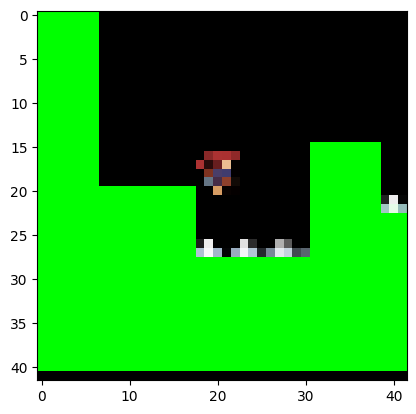

In [318]:
uh = json.loads(test)[0]
img = np.array(Image.open(io.BytesIO(base64.b64decode(uh))))[..., :3]
plt.imshow(img)

In [8]:
from celeste_rl.env_gym import CelesteImgGym

In [9]:
env = CelesteImgGym()


In [ ]:
l = list(test)



fk = np.array(l).reshape((180,320,4))



fk.dtype

resized = cv2.resize(fk.astype(np.uint8), (64,64), cv2.INTER_LANCZOS4)

plt.imshow(resized)

plt.imshow(fk)

In [ ]:
320*180*4

In [ ]:
b

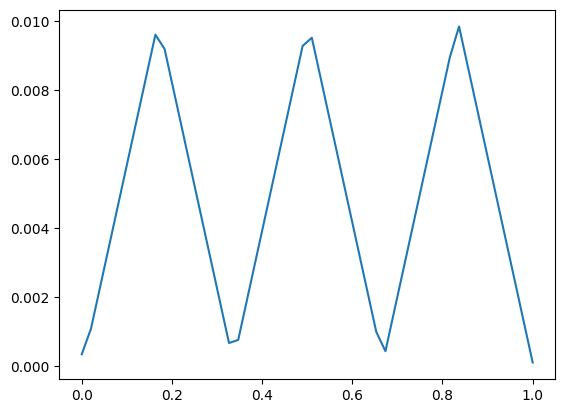

In [61]:
cyclic_schedule = CyclicLR(step_size=0.166)
ys = []
xs = np.linspace(0, 1)
ys = [cyclic_schedule.adapted_clr(x) for x in xs] 
plt.plot(xs,ys)

In [2]:
from pytorch_grad_cam import EigenCAM, EigenGradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [3]:
my_config = DEFAULT_CONFIG_DICT
my_config["interface"] = CelesteGym
my_config["time_step_duration"] = 0.06
my_config["start_obs_capture"] = 0.06
my_config["time_step_timeout_factor"] = 1.0
my_config["ep_max_length"] = 1_000_000
my_config["act_buf_len"] = 20
my_config["reset_act_buf"] = False
my_config["benchmark"] = True
my_config["benchmark_polyak"] = 0.2

env = gymnasium.make("real-time-gym-v1", config=my_config)

wrapenv = Monitor(FlattenerEnv(env))
model = PPO("MultiInputPolicy",
            wrapenv,
            n_steps=256,
            learning_rate=5e-3,
            policy_kwargs=dict(normalize_images=False,
                              features_extractor_class=CustomCombinedExtractor),
            verbose=1,
            device='cpu',
            tensorboard_log="./celeste_tensorboard/")

/home/leopaul/mambaforge/envs/zmq/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:29: UserWarning: WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: float32. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.
  logger.warn(
/home/leopaul/mambaforge/envs/zmq/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:34: UserWarning: WARN: It seems a Box observation space is an image but the lower and upper bounds are not [0, 255]. Actual lower bound: 0.0, upper bound: 1.0. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.
  logger.warn(
/home/leopaul/mambaforge/envs/zmq/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.war

Using cpu device
Wrapping the env in a DummyVecEnv.


In [ ]:
# testmodel = model.policy.features_extractor.extractors.image
# cam = EigenCAM(testmodel, [testmodel.cnn[0]])

# img = wrapenv.step(np.array([0,0,0,0,0,0,0]))[0]['image']
# input_tensor = th.tensor(img, dtype=th.float)[None, ...]
# cam_out = cam(input_tensor)
# rgb = LevelRenderer.cm(LevelRenderer.norm(img[0] + img.argmax(0)))

# plt.imshow(show_cam_on_image(rgb[:,:,:3], cam_out[0], use_rgb=True))

In [22]:
context = zmq.Context()
socket = context.socket(zmq.REQ)
socket.connect("tcp://localhost:7777")
initialized = True



In [ ]:
# %%timeit -n 1000 
# fullinp = th.cat([torch_obs['image'][:, [i,LevelRenderer.ID_MAP['Player']]] for i in range(LevelRenderer.max_idx+1) if i != LevelRenderer.ID_MAP['Player']], dim=1)

In [5]:
# %%prun -D learning.prof

# vec_env = model.get_env()
# obs = vec_env.reset()
# for i in range(1000):
#     action, _state = model.predict(obs, deterministic=True)
#     obs, reward, done, info = vec_env.step(action)

In [24]:
# In[10]:

my_config = DEFAULT_CONFIG_DICT
my_config["interface"] = CelesteGym
my_config["time_step_duration"] = 0.04
my_config["start_obs_capture"] = 0.04
my_config["time_step_timeout_factor"] = 1.0
my_config["ep_max_length"] = 1_000_000
my_config["act_buf_len"] = 4
my_config["reset_act_buf"] = False
my_config["benchmark"] = True
my_config["benchmark_polyak"] = 0.2

run = wandb.init(
    project="celesterl",
    config=my_config,
    sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
    monitor_gym=True,  # auto-upload the videos of agents playing the game
    save_code=True,  # optional
)

env = gymnasium.make("real-time-gym-v1", config=my_config)

wrapenv = Monitor(FlattenerEnv(env))
model = PPO("MultiInputPolicy",
            wrapenv,
            n_steps=2048,
            learning_rate=5e-3,
            policy_kwargs=dict(normalize_images=False,
                              features_extractor_class=CustomCombinedExtractor),
            verbose=1,
            device='cpu',
            tensorboard_log="./celeste_tensorboard/")

for i in range(10):

    model.learn(100_000)
    
    model.save(f'model2_{i}.sav')



wandb: Currently logged in as: boesingerl. Use `wandb login --relogin` to force relogin


/home/leopaul/mambaforge/envs/zmq/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:29: UserWarning: WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: float32. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.
  logger.warn(
/home/leopaul/mambaforge/envs/zmq/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:34: UserWarning: WARN: It seems a Box observation space is an image but the lower and upper bounds are not [0, 255]. Actual lower bound: 0.0, upper bound: 1.0. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.
  logger.warn(
/home/leopaul/mambaforge/envs/zmq/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.war

Using cpu device
Wrapping the env in a DummyVecEnv.


Logging to ./celeste_tensorboard/PPO_41


/home/leopaul/mambaforge/envs/zmq/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:188: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/leopaul/mambaforge/envs/zmq/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:164: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/leopaul/mambaforge/envs/zmq/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:188: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/leopaul/mambaforge/envs/zmq/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:164: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type:

KeyboardInterrupt: 